In [1]:
# set work dir
import os
os.chdir("../")

In [2]:
from copy import deepcopy
from types import SimpleNamespace

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.reload_library()
plt.style.use("science")
from matplotlib import cm
from matplotlib import ticker

from run import utils

Auto-Sklearn cannot be imported.


In [3]:
# init config
config = SimpleNamespace()
config.prob = "tsp"
config.nodes = 20
config.feat = 10
config.net = []
config.optm = "adam"
config.batch = 32
config.l1 = 0.0
config.l2 = 0.0
config.lan = "gurobi"
config.proc = 32
config.path = "./res"

In [4]:
# polynomial degree
degs = [1, 2, 4, 6]

In [5]:
def getPath(config, mthd):
    config = deepcopy(config)
    if mthd == "spo":
        config.mthd = "spo"
        config.lr = 1e-2
        config.form = "dfj"
        config.rel = False
    if mthd == "spo-rel(gg)":
        config.mthd = "spo"
        config.lr = 1e-2
        config.form = "gg"
        config.rel = True
    if mthd == "spo-rel(mtz)":
        config.mthd = "spo"
        config.lr = 1e-2
        config.form = "mtz"
        config.rel = True
    if mthd == "bb":
        config.mthd = "bb"
        config.lr = 5e-2
        config.form = "dfj"
        config.smth = 20
        config.rel = False
    if mthd == "bb-rel(gg)":
        config.mthd = "bb"
        config.lr = 5e-2
        config.form = "gg"
        config.smth = 20
        config.rel = True
    if mthd == "bb-rel(mtz)":
        config.mthd = "bb"
        config.lr = 5e-2
        config.form = "mtz"
        config.smth = 20
        config.rel = True
    path = utils.getSavePath(config)
    return path

In [6]:
def getDf(config, degs, mthd, col="Unamb SPO"):
    dfs = pd.DataFrame()
    for deg in degs:
        config.deg = deg
        df = pd.read_csv(getPath(config, mthd))
        dfs[deg] = df[col]
    return dfs

In [7]:
def getElapsed(config, data):
    df = pd.DataFrame(columns=["Method", "Data Size", "Noise", "Elapsed"])
    for mthd in ["spo", "spo-rel(gg)", "spo-rel(mtz)", "bb", "bb-rel(gg)", "bb-rel(mtz)"]:
        for noise in [0.0, 0.5]:
            config = deepcopy(config)
            config.data = data
            config.noise = noise
            # get df
            elapsed = getDf(config, degs, mthd, "Elapsed").mean(axis=1).mean() / (1000 if data == 100 else 300)
            row = {"Method":mthd, "Data Size":data, "Noise":noise, "Elapsed":elapsed}
            df = df.append(row, ignore_index=True)
    df = df.drop(columns=["Noise"]).groupby(["Method", "Data Size"], as_index=False).mean()
    # order list
    lst = []
    for mthd in ["spo", "spo-rel(gg)", "spo-rel(mtz)", "bb", "bb-rel(gg)", "bb-rel(mtz)"]:
        lst.append(df[df["Method"]==mthd]["Elapsed"].values[0])
    return lst

In [8]:
def drawBarPlot(config):
    values1 = getElapsed(config, 100)
    values2 = getElapsed(config, 1000)
    # color map
    cmap = cm.get_cmap("Set2")
    colors = cmap(np.linspace(0, 1, 8))
    color_backup = [colors[2], "lightblue", "skyblue", colors[3], "lightpink", "palevioletred"]
    # draw boxplot
    fig = plt.figure(figsize=(16,6))
    x = range(6)
    bar1 = plt.bar([i-0.2 for i in x], height=values1, width=0.4, alpha=0.8, edgecolor="w", 
                   linewidth=3, hatch="//", color=color_backup, label="Training Set Size = 100")
    bar2 = plt.bar([i+0.2 for i in x], height=values2, width=0.4, alpha=0.8, edgecolor="w",
                   linewidth=3, hatch="..", color=color_backup, label="Training Set Size = 1000")
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # labels and ticks
    plt.xlim(-0.5, 5.5)
    plt.xticks(ticks=[0,1,2,3,4,5], fontsize=22,
               labels=["SPO+\n(DFJ)", "SOP+ Rel\n(GG)", "SPO+ Rel\n(MTZ)", "DBB\n(DFJ)", "DBB Rel\n(GG)", "DBB Rel\n(MTZ)"])
    plt.ylabel("Runtime per Epoch (Sec)", fontsize=36)
    plt.yticks(fontsize=24)
    leg = plt.legend(fontsize=22, loc=2, labelspacing=0.2)
    lh = leg.legendHandles
    lh[0].set_color("grey")
    lh[0].set_edgecolor("w")
    lh[1].set_color("grey")
    lh[1].set_edgecolor("w")
    # save
    plt.show()
    fig.savefig("./images/rel-tsp-time.png", dpi=600)

In [9]:
def drawPlot(config, data, noise):
    # set config
    config = deepcopy(config)
    config.data = data
    config.noise = noise
    # get df
    df_spo_dfj  = getDf(config, degs, "spo")
    df_spo_gg  = getDf(config, degs, "spo-rel(gg)")
    df_spo_mtz = getDf(config, degs, "spo-rel(mtz)")
    df_dbb_dfj  = getDf(config, degs, "bb")
    df_dbb_gg  = getDf(config, degs, "bb-rel(gg)")
    df_dbb_mtz = getDf(config, degs, "bb-rel(mtz)")
    # color map
    cmap = cm.get_cmap("Set2")
    colors = cmap(np.linspace(0, 1, 8))
    # draw boxplot
    fig = plt.figure(figsize=(16,6))
    c = colors[2]
    bp1 = plt.boxplot(df_spo_dfj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo_dfj.shape[1])-0.4, widths=0.12)
    c = "lightblue"
    bp2 = plt.boxplot(df_spo_gg, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo_dfj.shape[1])-0.24, widths=0.12)
    c = "skyblue"
    bp3 = plt.boxplot(df_spo_mtz, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_spo_dfj.shape[1])-0.08, widths=0.12)
    c = colors[3]
    bp4 = plt.boxplot(df_dbb_dfj, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.08, widths=0.12)
    c = "lightpink"
    bp5 = plt.boxplot(df_dbb_gg, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.24, widths=0.12)
    c = "palevioletred"
    bp6 = plt.boxplot(df_dbb_mtz, boxprops=dict(facecolor=c, color=c, linewidth=4), medianprops=dict(color="w", linewidth=2),
                      whiskerprops=dict(color=c, linewidth=2), capprops=dict(color=c, linewidth=2),
                      flierprops=dict(markeredgecolor=c, marker="o", markersize=5, markeredgewidth=2),
                      patch_artist=True, positions=np.arange(df_dbb_dfj.shape[1])+0.4, widths=0.12)    
    # vertical line
    plt.axvline(x=0.5, color="k", linestyle="--", linewidth=1.5)
    plt.axvline(x=1.5, color="k", linestyle="--", linewidth=1.5)
    plt.axvline(x=2.5, color="k", linestyle="--", linewidth=1.5)
    # grid
    plt.grid(color="grey", alpha=0.5, linewidth=0.5, which="major", axis="y")
    # labels and ticks
    plt.xlabel("Polynomial Degree", fontsize=36)
    plt.xticks(ticks=[0,1,2,3], labels=[1,2,4,6], fontsize=28)
    plt.ylabel("Normalized Regret", fontsize=36)
    plt.yticks(fontsize=24)
    plt.xlim(-0.5, 3.5)
    plt.ylim(-0.02, 0.58)
    ax = plt.gca()
    ax.yaxis.set_major_formatter(ticker.FormatStrFormatter("%.2f"))
    plt.title("Training Set Size = {},\nNoise Half−width = {}".format(config.data, config.noise), fontsize=30)
    plt.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0], bp4["boxes"][0], bp5["boxes"][0], bp6["boxes"][0]],
               ["SPO+ (DFJ)", "SPO+ Rel(GG)", "SPO+ Rel(MTZ)", "DBB (DFJ)", "DBB Rel(GG)", "DBB Rel(MTZ)"],
               fontsize=20, loc=2, labelspacing=0.2, handlelength=1, ncol=2)
    # save
    plt.show()
    fig.savefig("./images/rel-tsp-n{}e{}.png".format(data,int(10*noise)), dpi=600)

## Elapsed Time 

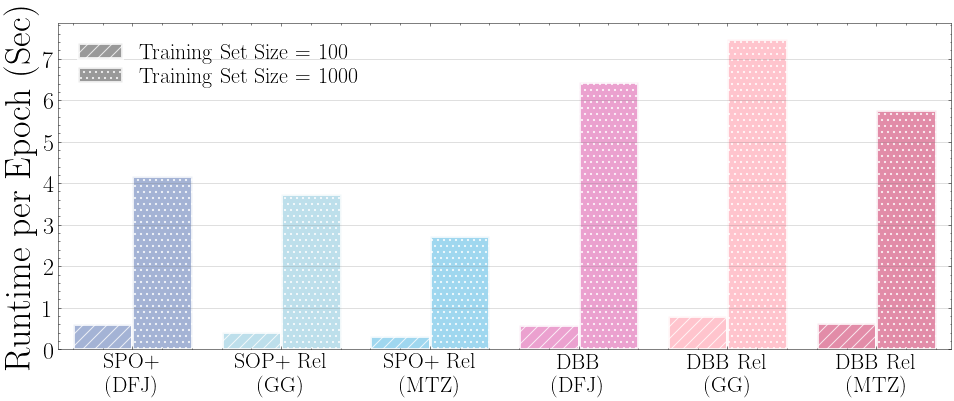

In [10]:
drawBarPlot(config)

## n = 100, e = 0

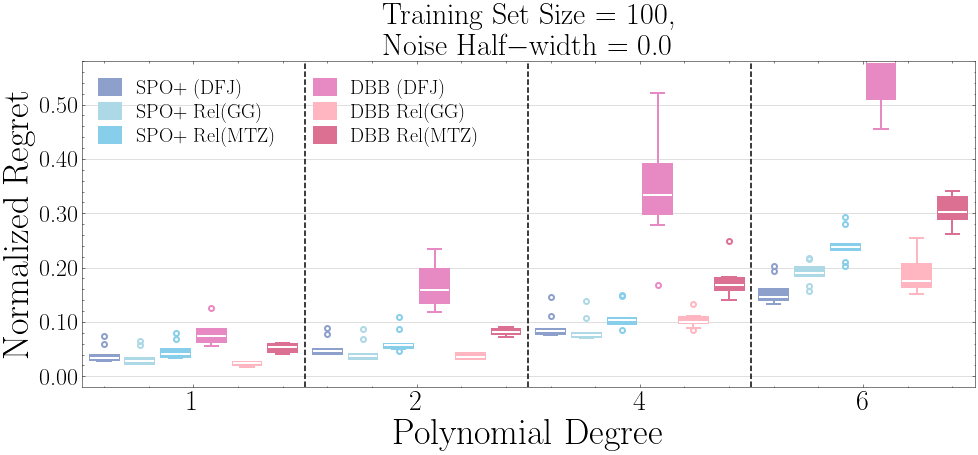

In [11]:
drawPlot(config, data=100, noise=0.0)

## n = 100, e = 0

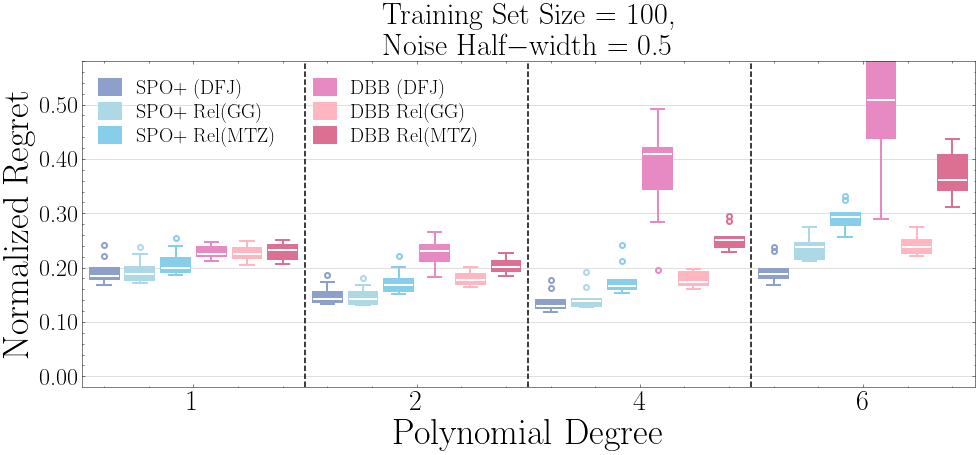

In [12]:
drawPlot(config, data=100, noise=0.5)

## n = 1000, e = 0

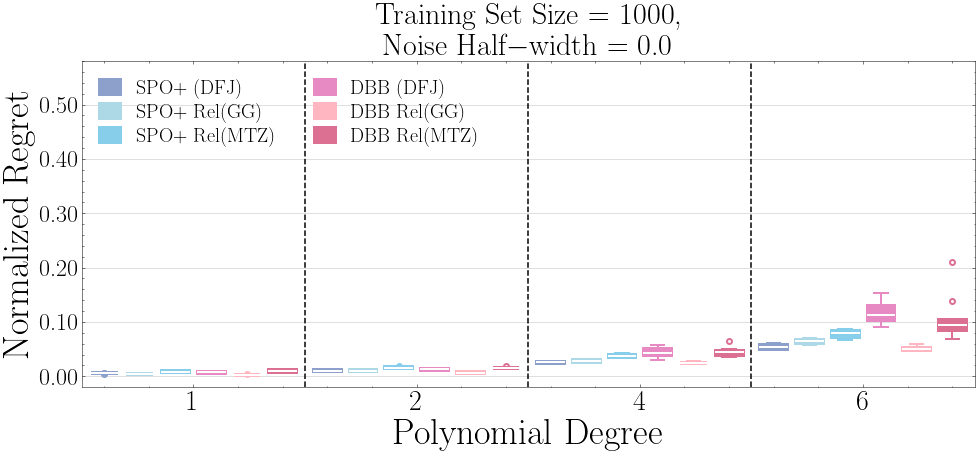

In [13]:
drawPlot(config, data=1000, noise=0.0)

## n = 1000, e = 0.5 

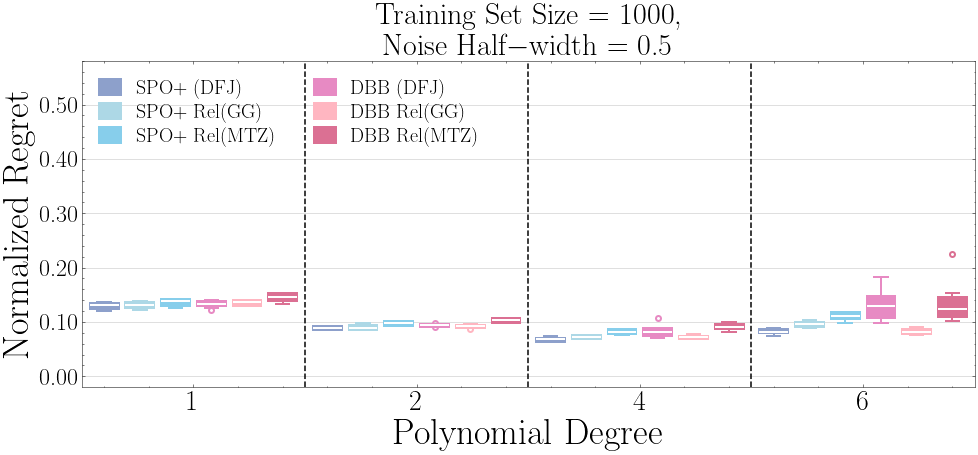

In [14]:
drawPlot(config, data=1000, noise=0.5)